In [5]:
#--- Preamble

# Visualizers
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install seaborn --upgrade

plt.rcParams['figure.dpi'] = 150   # Increase figure resolution
plt.rcParams['savefig.dpi'] = 150

# Data computation and manipulation
import numpy as np
import pandas as pd
import scipy.optimize as sop
import scipy.stats as sps

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(42)  # Set seed - reproducibility

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# For permutations
import itertools

Paths accross my machines:
- "C:/Users/andre/Python Notebooks/ML Myroslav Project/MLdata.dat"
- "C:/Users/andre/Python Notebooks/TimeResolutionImprovement-ML/MLdata.dat"
- "C:/Users/Andrei/Jupyter Notebooks others/ML Myroslav Project"
- "C:/Users/Andrei/Documents/GitHub/TimeResolutionImprovement-ML/MLdata.dat"

In [10]:
# Read the data
# There is an extra redundant column to drop
data = pd.read_csv("C:/Users/lenovo/Downloads/MLdata.dat", sep=",").drop(columns=["Unnamed: 19"])
data_np = data.to_numpy()

# Introduction

The objectives of this notebook are:

- plot correlation matrix to identify the relevant features from the 'MLdata.dat' file. *Select a few features where the correlation is strongest*. Because most information is contained in them, we can use those to train the machine
- use an algorithm to actually fit the data and obtain predictions for T_0 (in team with Ramon. I do one, he does the other). Aim to follow all steps in End-to-End ML: *Plot data nicely, give it a good overview (part of step 1.)* and *Fit, find the best hyperparameters with a grid search, plot the results and the predictions*

**Note**. If I can: Compute confidence intervals. Check again validation/verification methods in “Intro to ML2” if I can do anything else

**The meaning of each data point**

Myroslav: "Few words on the T_zero data. The ML timing (T_ML) is related to the T_zero as following: T_ML+T_zero=const. A the constant you might take zero, and therefore: T_ML = -T_zero. So, you can use -T_zero as the true value for training..."

- Ch = The detector that recorded the fellas (first work with a single detector. Have a single bias in the data)

- E = energy deposition in arbitrary units (careful with scaling to provide to the machine). Low amplitude -> low time resolution. Best to keep the arbitrary units

- dT = T_detector2 - T_detector1. Myroslav will correct T_0 with it. Ideally it would be perpetually constant (depending only on the geometry setup); a challenge how to incorporate it effectively. What to do with the info that the difference between T_0 and T_1 varies?

- T_i = the time to exceed i0% of the final amplitude you record in the end. It was found by looking at the waveform (the 200 samples), fitting a linear function for the region locally where it exceeds the threshold and extrapolating the time.

- I_i = the value of the CDF when we exceeded i0%

**End to end ML**

1. Define the task
2. Get the data
3. Choose the right representation
4. Get an overview
- summary statistics (location, scale, shape, multivariate analysis)
- visualizations
5. Prepare the data
- data cleaning (missing values)
- standardisation, outlier detection, transformations (polynomial, logarithmic)
6. Select a model
- based on volume, complexity of data, assumptions about distributions and shape
7. Train and evaluate
- on training set (cross-validation)
- fine-tune model - optimize hyperparameters (grid search, randomized search)
8. Evaluate on test set
9. Launch, monitor, maintain

# Visualize and Prepare the Data

Intepretations on:

1. 'Correlation Matrix - all features':

- Compared to the other features, $dT$ looks to be weakly correlated to the others. However there is some correlation to exploit. 
- Beginning T's are very well correlated to their neighbours (to be expected from a smooth curve); fairly correlated to latter T's (0.7). A similar trend happens with the CDF, but the correlation is overall weaker

2. 'Correlation Plot - dT':

- Features with correlation over $5\%$: E (very promising), T3/4 (close but weaker: T2/5/6), I1 (pretty good), I3/4/7 (close but weaker: I2/5), I8 (very promising)
- So one use: E, I8, I1, I3/4/7, T3/4 (in this order). Include the weaker ones if needed

3. 'Correlations of multiple features':

- Ti's tend to have a high correlation among themselves (above $80\%$). I1 is anomalously low compared to the rest. As expected, the farther you go, the weaker the correlation

4. 'Scatter plots':

- dT vs I5/6/7/8 has a very interesting distribution (almost cross-like). There is some information stored in there, which we can use
- dT vs E is also very usable
- Conclusions with the correlation plots agree; but more emphasis is placed on I5/6/7/8

5. 'Histogram of dT':

- Statistical testing shows with a p-value below $0.01\%$ that the distribution is not normal, nor Lorentzian. Though the Lorenzian fit looks pretty good.
- The distribution not being normal would be a good omen: there is some information stored in the distribution to be exploited.

**Notes**

Spearman correlation gives similar results as Pearson correlation.

**Question and answers**

Q: Appropriateness of conclusions? Which are important?
A: Use middle T's and middle I's. It is to be expected that the beginning T's have less correlation, as there is a lot of noise in that region (low SNR- signal to noise ratio). Similar with beginning I's (all curves look the same in the beginning) & late I's (because of normalization to the top values, all I's reach 1 - no info to be had from there). 
- Discard E and I1, I8 for now. Uue T3/4/5, I3/4/5
- Previously: X = data[["E", "I_0.1", "I_0.5", "I_0.6", "I_0.7", "I_0.8", "T_0.3", "T_0.4"]]


Q: Should we standardize data? If it will be used for live acquisition... we don't know what the mean/variance to correct with are. 
A: No! Because it will be used in live acquisition, so for a different detector we don't know by which mean & standard deviation to subtract.

Q: Recommended scheme to search for hyperparameters?
A: *TO BE FOUND*

In [3]:
data.head()

,Ch,E,dT,T_0.1,T_0.2,T_0.3,T_0.4,T_0.5,T_0.6,T_0.7,T_0.8,I_0.1,I_0.2,I_0.3,I_0.4,I_0.5,I_0.6,I_0.7,I_0.8
0,0,4265,-5.01024,24.7775,32.2352,38.1801,43.7219,49.5611,56.2060,62.9037,70.1425,0.242294,1.29879,2.71460,4.36937,6.96861,10.7412,14.5353,20.4419
1,0,4543,-24.07050,29.1239,38.8918,46.5763,52.9984,59.9972,68.7666,78.5307,87.3346,0.645294,1.87594,3.72313,5.68355,8.71383,13.5489,19.9223,26.5768
2,0,1620,-2.26417,27.4213,37.0585,44.8142,54.1028,63.9510,70.7024,77.0351,84.8896,0.310760,1.72022,3.37024,6.80867,10.71700,14.3874,18.8636,24.0574
3,0,4511,-14.16570,26.7754,35.3079,42.2499,48.5413,55.2529,62.9482,70.4380,78.6220,0.433318,1.64869,3.30293,5.31327,8.39327,12.1350,17.2077,23.1260
4,0,4528,-18.15620,27.1780,35.3654,42.1512,48.2487,53.8233,59.4832,65.3871,72.5385,0.517805,1.59986,3.26604,5.27653,7.42717,10.6113,14.4264,19.6266


In [15]:
data_np.shape

(7578, 19)

In [5]:
data.columns

Index(['Ch', 'E', 'dT', 'T_0.1', 'T_0.2', 'T_0.3', 'T_0.4', 'T_0.5', 'T_0.6',
       'T_0.7', 'T_0.8', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6',
       'I_0.7', 'I_0.8'],
      dtype='object')

## Find the correlation

In [8]:
# Build correlation matrix
data_corr = data.drop(columns=["Ch"]).corr(method="spearman")
# Convert to numpy array

data_corr_np = data_corr.to_numpy()

#print(data_corr_np)
print(data_corr.columns)

Index(['E', 'dT', 'T_0.1', 'T_0.2', 'T_0.3', 'T_0.4', 'T_0.5', 'T_0.6',
       'T_0.7', 'T_0.8', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.5', 'I_0.6',
       'I_0.7', 'I_0.8'],
      dtype='object')


### Display correlation matrix

**Version 1**

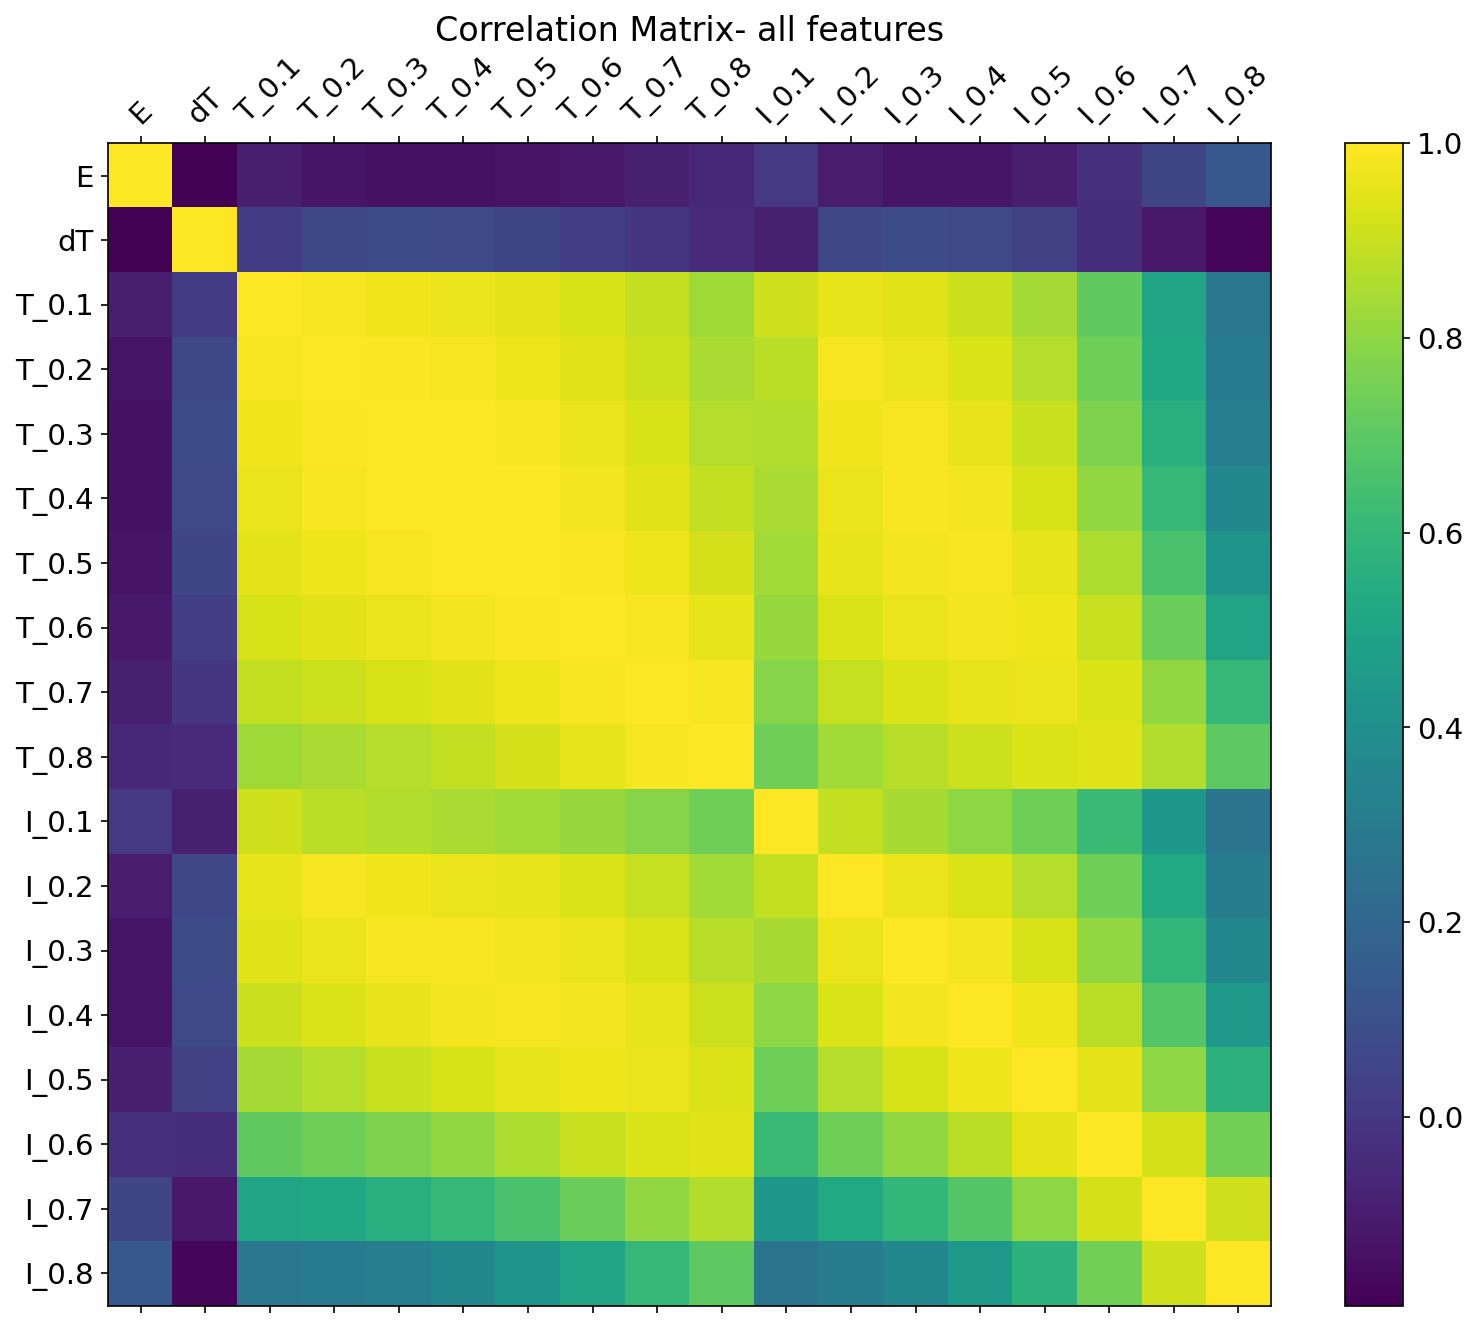

In [6]:
fig = plt.figure(figsize=(12.7, 10)) # 19 15

plt.matshow(data_corr, fignum=fig.number)

plt.xticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(data_corr.shape[1]), data_corr.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('Correlation Matrix- all features', fontsize=16)

# Save figure. Put Plt.show() after
#plt.savefig('Correlation Matrix- all features.png', bbox_inches='tight')
plt.show()

**Version 2**

Text(0.5, 1.0, 'Correlation Matrix')

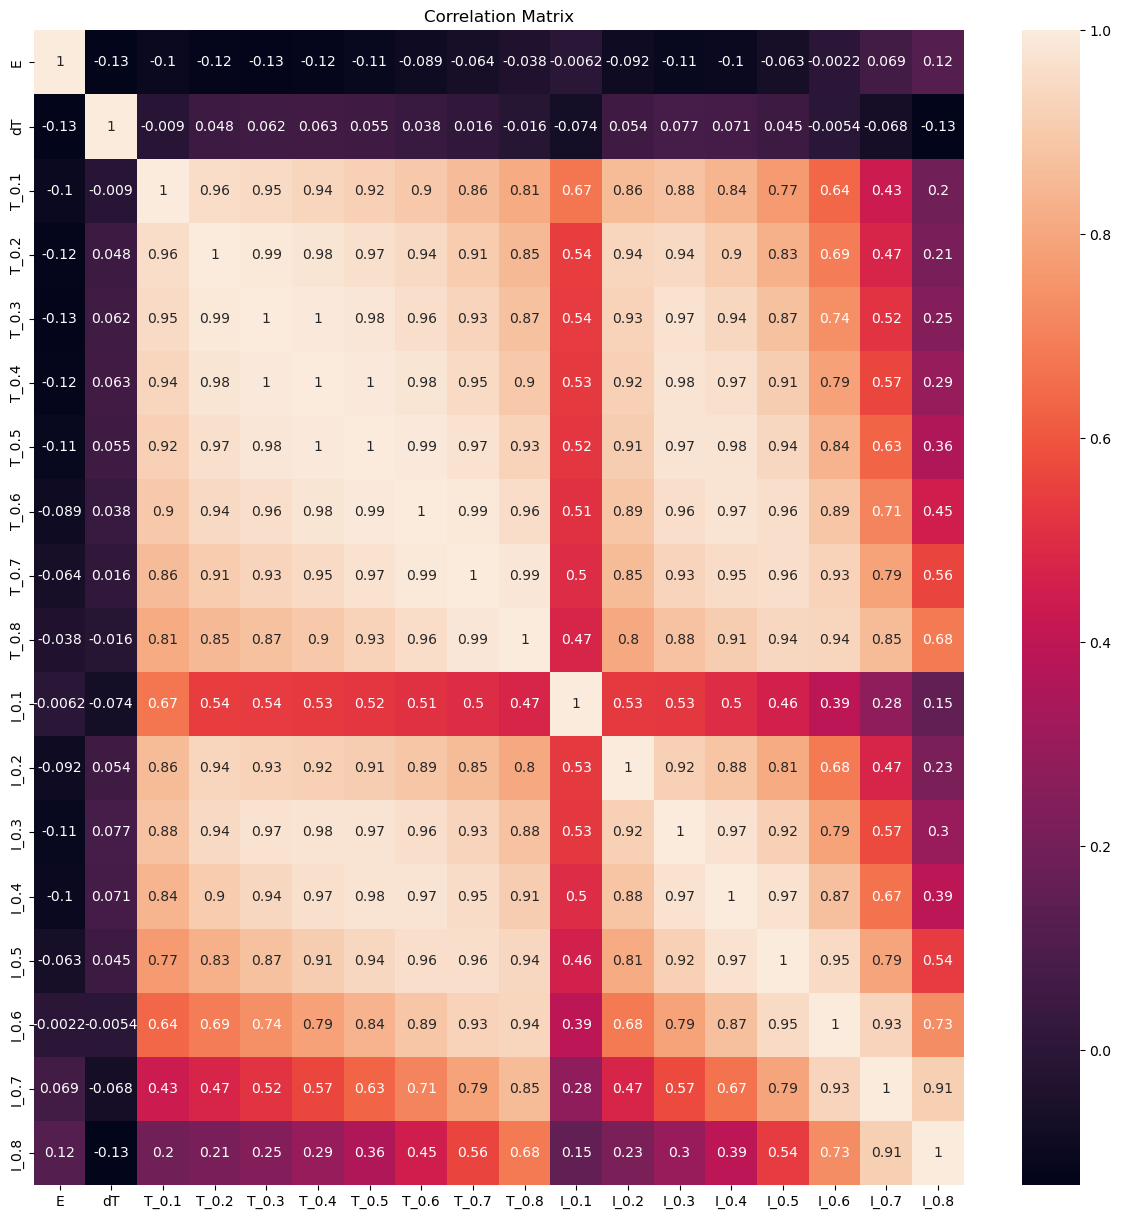

In [6]:
plt.figure(figsize=(15, 15))
ax = plt.subplot()
sns.heatmap(data_corr, annot=True, ax = ax);
ax.set_title('Correlation Matrix')

### Graphs of correlation

Show the correlation between the beginning times (and CDFs) and the other variables involved. We want to see if there is any useful hidden relationship we can exploit.

*Question*: What is an adequate minimum correlation that we could use?

dT. Columns over threshold: ['E', 'T_0.2', 'T_0.3', 'T_0.4', 'T_0.5', 'I_0.1', 'I_0.2', 'I_0.3', 'I_0.4', 'I_0.7', 'I_0.8']


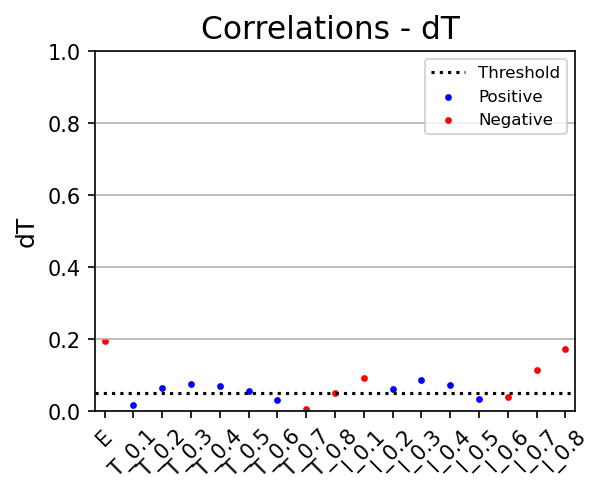

In [9]:
# --- Create a display function

# Treat columns as indices
# Use indices to refer back to the names
col_index= {i: c for i, c in enumerate(data_corr.columns)}

def correlation_plotter(ax, index=1, threshold=0, print_val=False,
                       zoom=False):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the correlation using the 'index' row. Additional features:
    
    - plots the absolute value only, but in different colors depending on the sign
    - prints the values and columns exceeding an imposed threshold
    - dynamically changes the scaling of the y axis for zooming in
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - index = Integer. It denotes the number of the row to be compared 
    with all other features. To see which column index corresponds to, 
    evaluate 'col_index[index]'
    - threshold = Float. It denoted the value to be exceeded by the
    absolute value of the correlations
    - print_val = Boolean. If true, it displays which columns exceed the
    threshold mentioned above
    - zoom = Boolean. If true, it dynamically changes the yrange such that
    one focuses only on values between 0 and roughly the maximum of the achieved
    correlations
    
    --- Returns:
    
    - axis is changed according to the specifications
    - if print_val=True, the columns above the threshold are printed
    
    --- BUGS:
    
    - printing the values over the threshold does not take into account the fact
    that we delete the feature from the y axis that was on the x axis
    """
    
    # Interested only in correlations excluding the variable itself
    mask = data_corr_np[index] < 1
    corr = data_corr_np[index][mask]  
    
    # xticks for plotting convenience
    xticks = np.array([1 + 3*i for i in range(len(corr))])
    
    # Separate the correlations via signs for different colors
    mask_pos = corr >= 0
    mask_neg = np.logical_not(mask_pos)
    
    corr_pos = corr[mask_pos]
    corr_neg = np.abs(corr[mask_neg])
    
    xticks_pos = xticks[mask_pos]
    xticks_neg = xticks[mask_neg]
    
    # Identify all points above the threshold
    if threshold > 0:
        _ = np.nonzero(np.abs(corr) > threshold)[0]
        # Offset values after the deleted index by 1
        # so it prints the correct column
        _[_ > index] += 1
        
        if print_val == True:
            if len(_) == 0:
                print(f"No correlations above {threshold}")
            else:
                print(f"{col_index[index]}. Columns over threshold: {[col_index[i] for i in _]}")
    
    # The plotting itself
    ax.set_title(f"Correlations - {col_index[index]} ", fontsize=15)
    
    if threshold > 0:
        ax.hlines(y=threshold, xmin=0, xmax=xticks[-1] + 1, 
                  color="black", linestyle=":", label="Threshold")
    
    ax.scatter(xticks_pos, corr_pos, c="blue", s=5, label="Positive")
    ax.scatter(xticks_neg, corr_neg, c="red", s=5, label="Negative")

    ax.grid(axis='y')
    ax.legend(fontsize=8)

    ax.set_ylabel(f"{col_index[index]}", fontsize=12)
    ax.set_xlim(0, xticks[-1] + 1)
    
    # Dynamically change the yrange -- TO BE FIXED
    if zoom == True:
        ymax = min(1, 0.1*np.ceil(10 * np.max(np.abs(corr))))
        ax.set_ylim(0, ymax)
    else:
        ax.set_ylim(0, 1)
    
    _ = np.nonzero(np.logical_not(mask))[0][0] # Drop the removed variable from ticks
    ax.set_xticks(xticks, data_corr.drop(columns=[col_index[_]]).columns, fontsize=10, rotation=45)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
# Test the function

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.5, 0.5])
correlation_plotter(ax, index=1, threshold=0.05, print_val=True, zoom=True)

# Save figure
#plt.savefig('Correlation Matrix- dT.png', bbox_inches='tight')

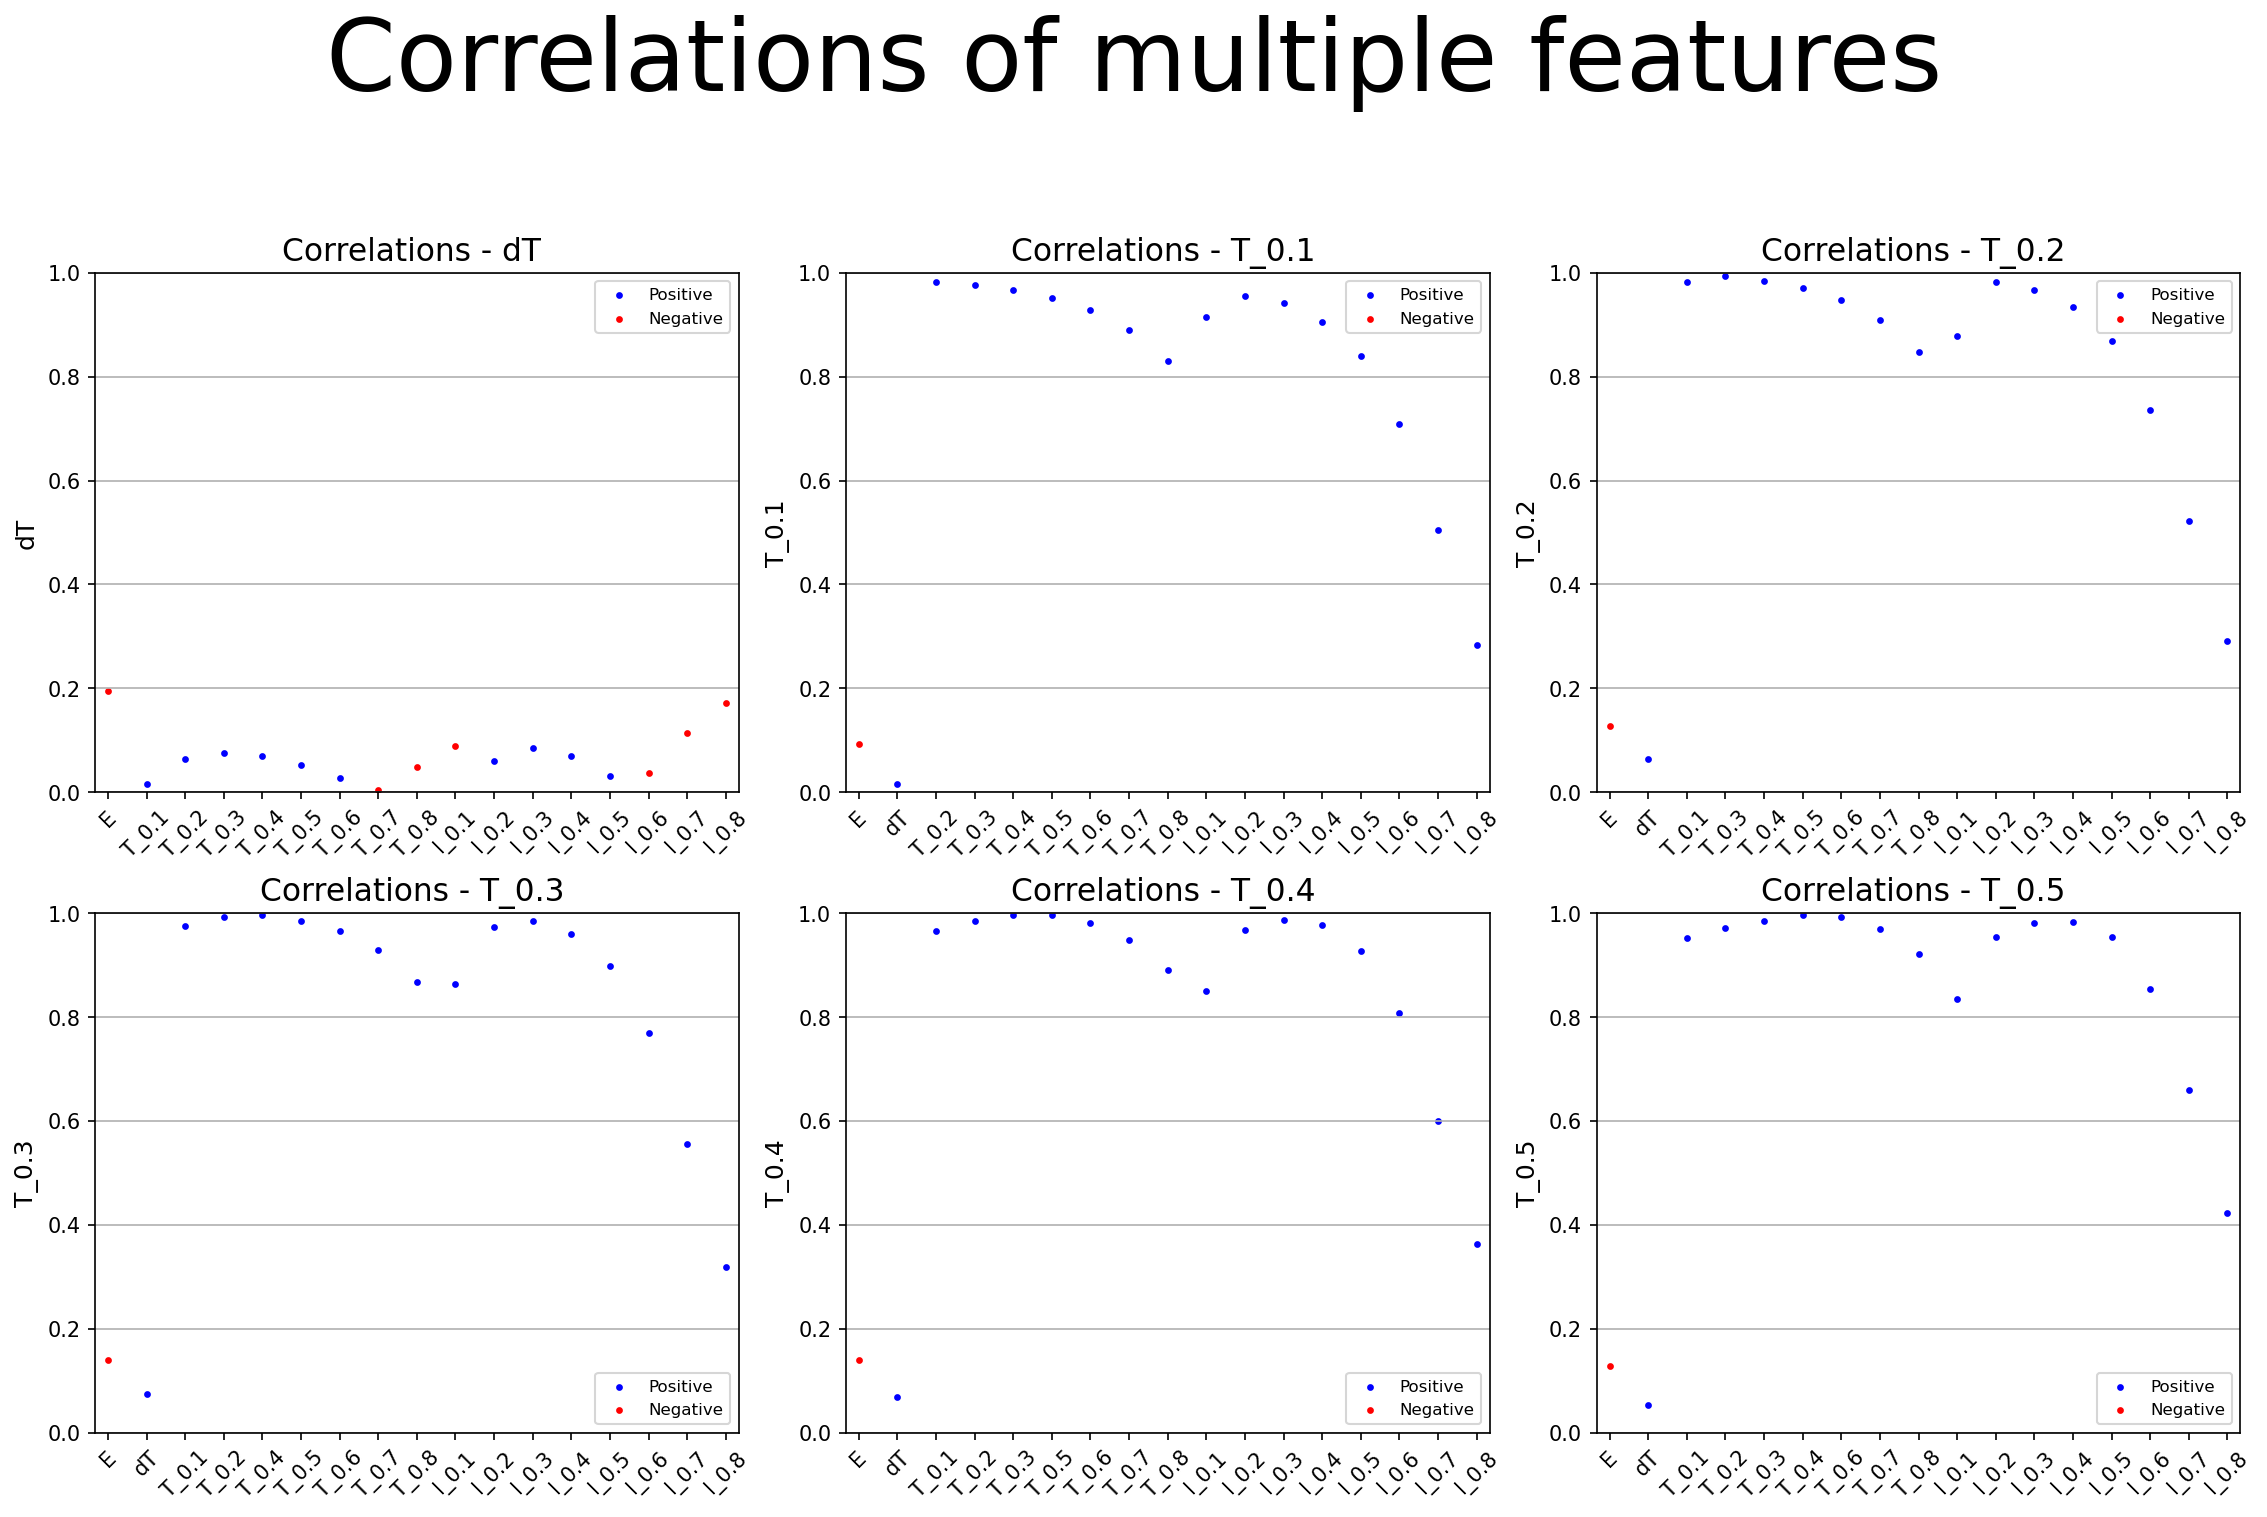

In [10]:
#--- Create subplots of correlations
# Inspired from Ramon's code

# Define the indices where we want to analyze correlations
indices = [1, 2, 3, 4, 5, 6]
num_rows = len(indices) // 3

fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

# Plot each correlation
for index, ax in zip(indices, axs.flatten()):
    correlation_plotter(ax, index=index)
    
fig.suptitle('Correlations of multiple features\n', size=48)

#plt.savefig('Correlations of multiple features.png', bbox_inches='tight')
plt.show()

### Scatter Plot Matrix

Thank you, Ramon! :)

% Add which graphs present the most structure after the labels are fixed

The histogram of $dT$ shows an approximately normal distribution. It may indicate that there is an average $dT$ where the particle first enters the detector, but which is affected by noise.

**To be further investigated**

- A normal fit onto the histogram

In [23]:
#--- Define a function to do the scatter plot:

def scatter_plotter(ax, index_1, index_2):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the data set. 
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - index_1, index_2 = Integers. It denotes the index of the features
    to be plotted against each other. To see which column index corresponds to, 
    evaluate 'col_index[index]', but offset by 1 due to not deleting the channel column.
    e.g. col_index[0] = E, but the index is 1 for data_np.T
    
    Important note: both indeces must be greater than 0. 
    
    --- Returns:
    
    - axis is changed according to the specifications
    """
    if index_1 == 0 or index_2 == 0:
        print("Invalid choice of index.")
        return 0
    
    # Transpose to easily plot columns
    data_ = data_np.T
    
    # The plotting
    ax.set_title(f"{col_index[index_2-1]} vs. {col_index[index_1-1]}", fontsize=15)
    
    ax.scatter(data_[index_1], data_[index_2], c="blue", s=5, label="Data")
    ax.legend(fontsize=8)
    
    ax.set_xlabel(f"{col_index[index_1-1]}", fontsize=12)
    ax.set_ylabel(f"{col_index[index_2-1]}", fontsize=12)
    
def scatter_matrix_plotter(indices_1, indices_2, save_fig=False):
    """
    Creates a scatter mattrix plot of each feature given by
    indices_1 and indices_2. It relies on the function 
    scatter_plotter.
    
    --- Inputs:
    
    indices_1, indices_2 = Array-like. Each contains a list of all index_1, 
    respectively index_2 variables to be used by scatter_plotter. Both must
    have the same length!
    
    save_fig = Boolean. If true, it saves the subplots as a PNG
    
    --- Returns:
    
    A subplot.
    """
    
    num_rows = len(indices_1) // 3
    
    fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

    for index_1, index_2, ax in zip(indices_1, indices_2, axs.flatten()):
        scatter_plotter(ax, index_1=index_1, index_2=index_2)

    fig.suptitle('Scatter plot of multiple features\n', size=48)
    
    if save_fig == True:
        plt.savefig('Scatter plots of dT.png', bbox_inches='tight')
    
    plt.show()

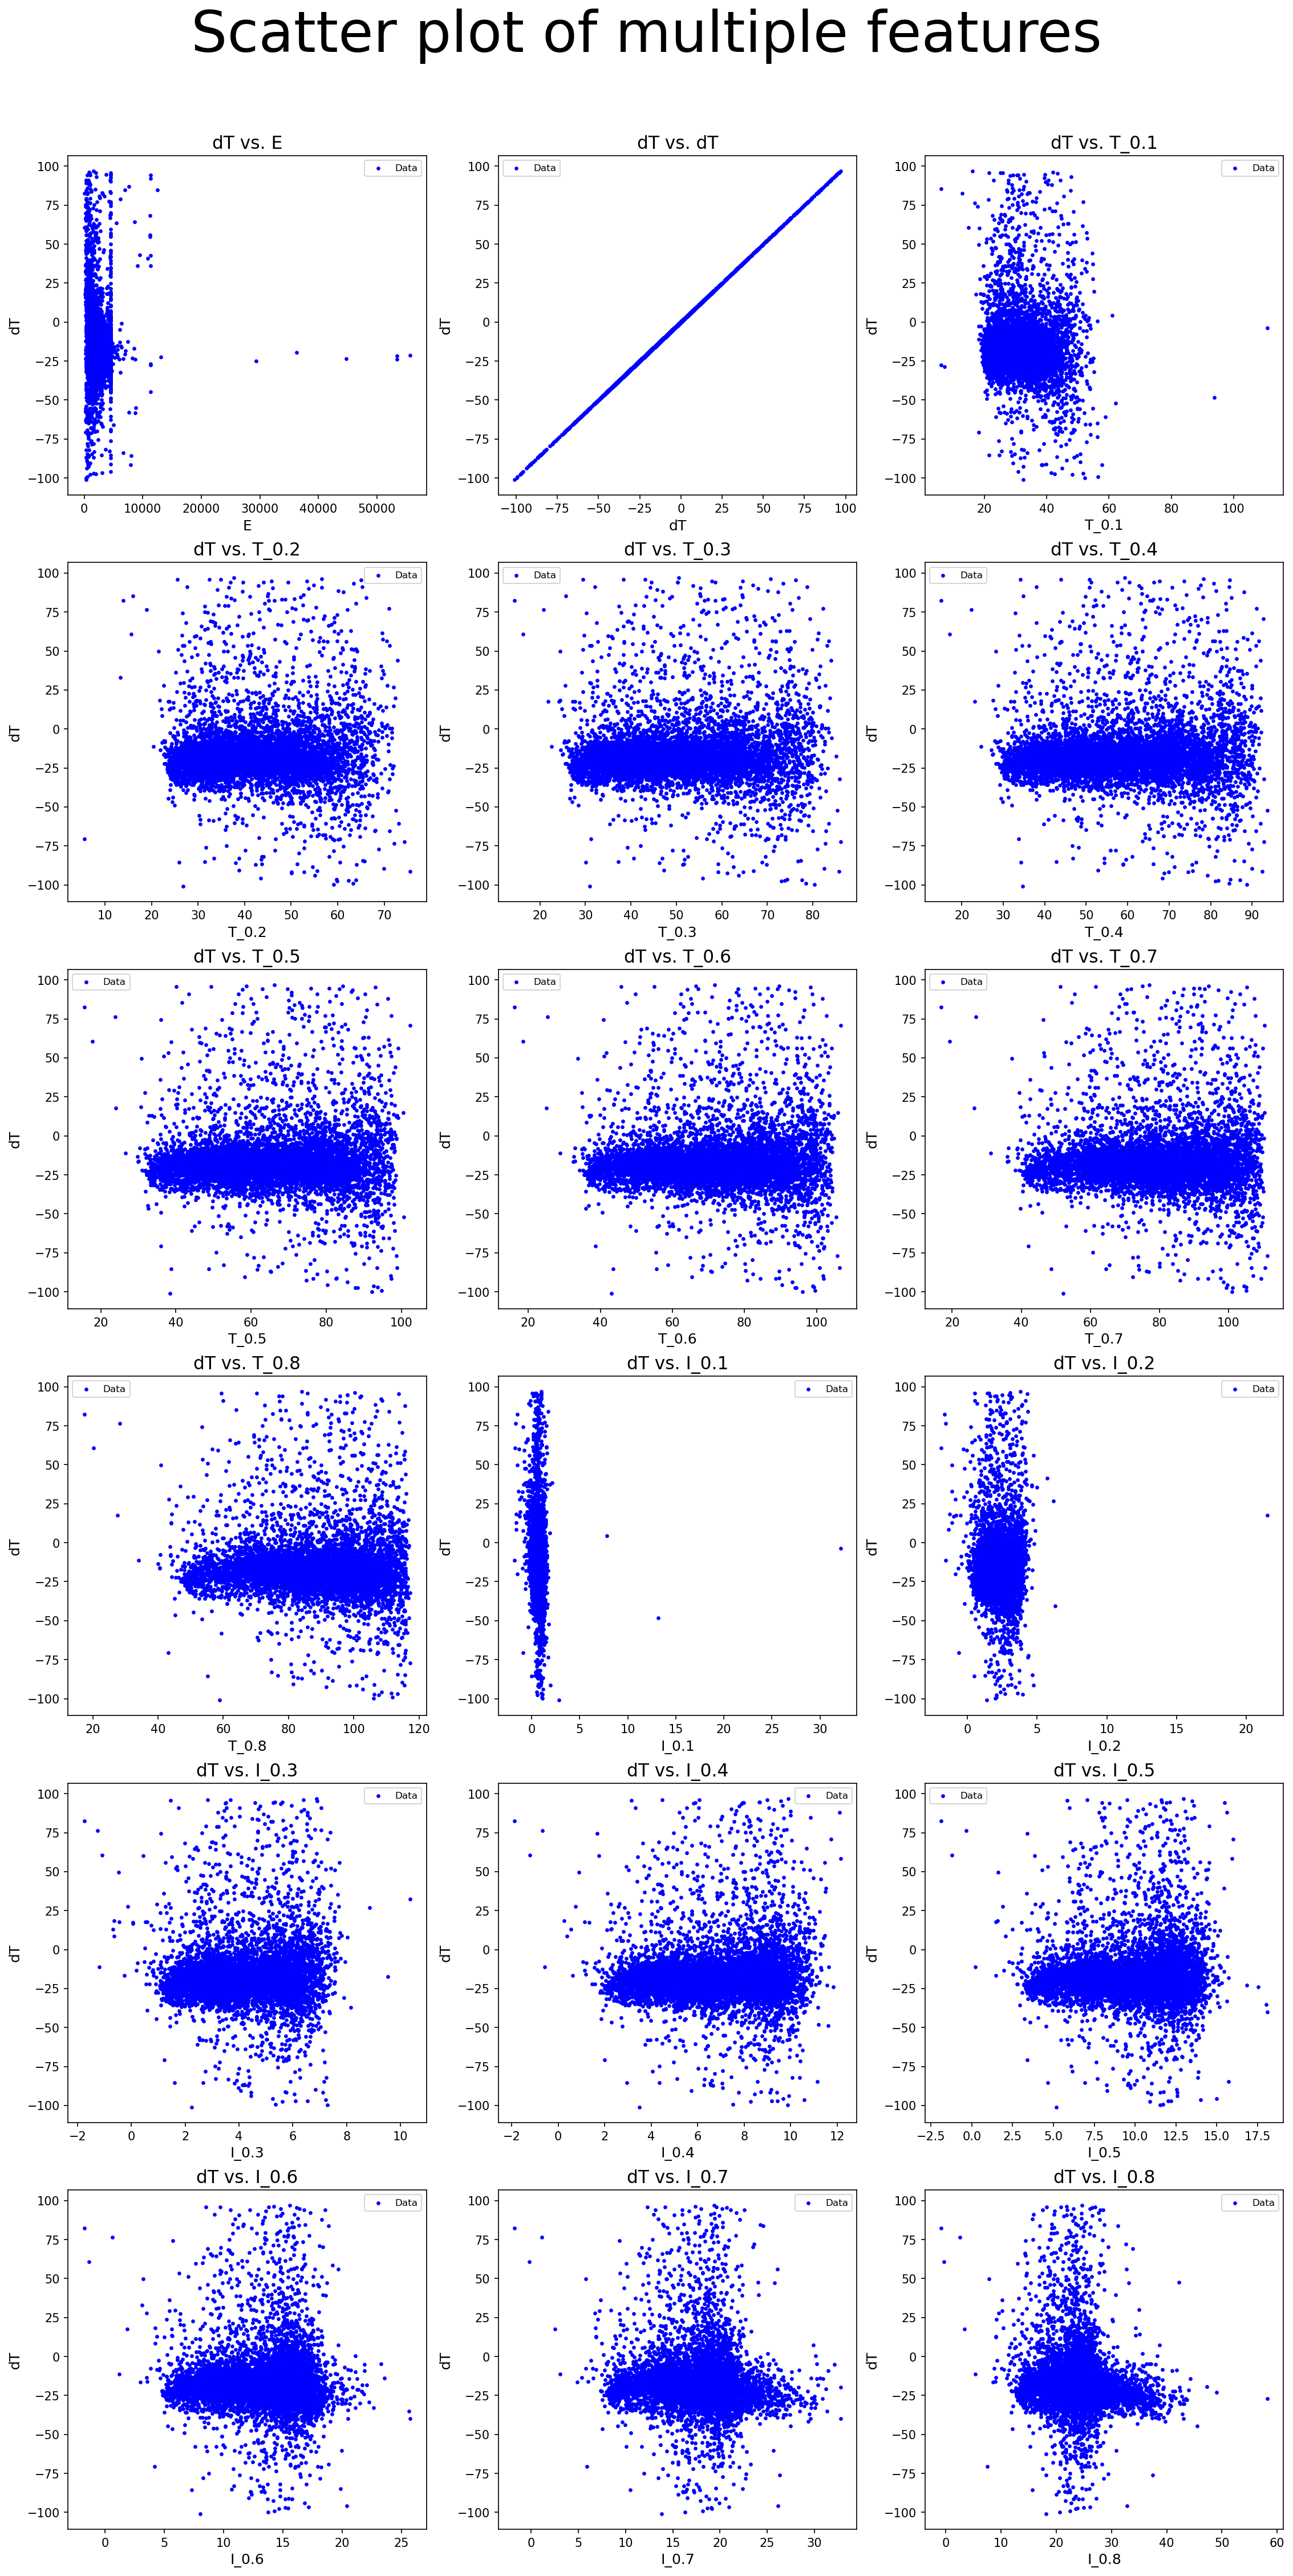

In [24]:
#--- Scatter plots

# Define the indices to analyze
indices_1 = np.arange(1, data_np.shape[1])
indices_2 = 2 * np.ones(len(indices_1), dtype=np.int8)

scatter_matrix_plotter(indices_1, indices_2)

### Histogram of dT

See what kind of distribution $dT$ has. The histogram shows that it roughly follows a bell shape, but to test that we go to 'scipy.stats.normaltest'. The null hypothesis is that it comes from a normal distribution. 

The p-value for the test is $0.0$ (so less than $10^{-113}$ - the result of another dataset that gave non-zero). This means: "Given $H_0$ true = sample is normally distributed, the probability of the statistic finding a result at least as extreme in the rejection region = not normally distributed is pretty much $0$".

**dT is not normally distributed**

*Note*. Code sample to test the interpretation of p-values on two toy distributions:

"
temp1 = np.random.uniform(size=10_000)
temp2 = np.random.normal(size=10_000)

print(sps.normaltest(temp1).pvalue, sps.normaltest(temp2).pvalue)
"

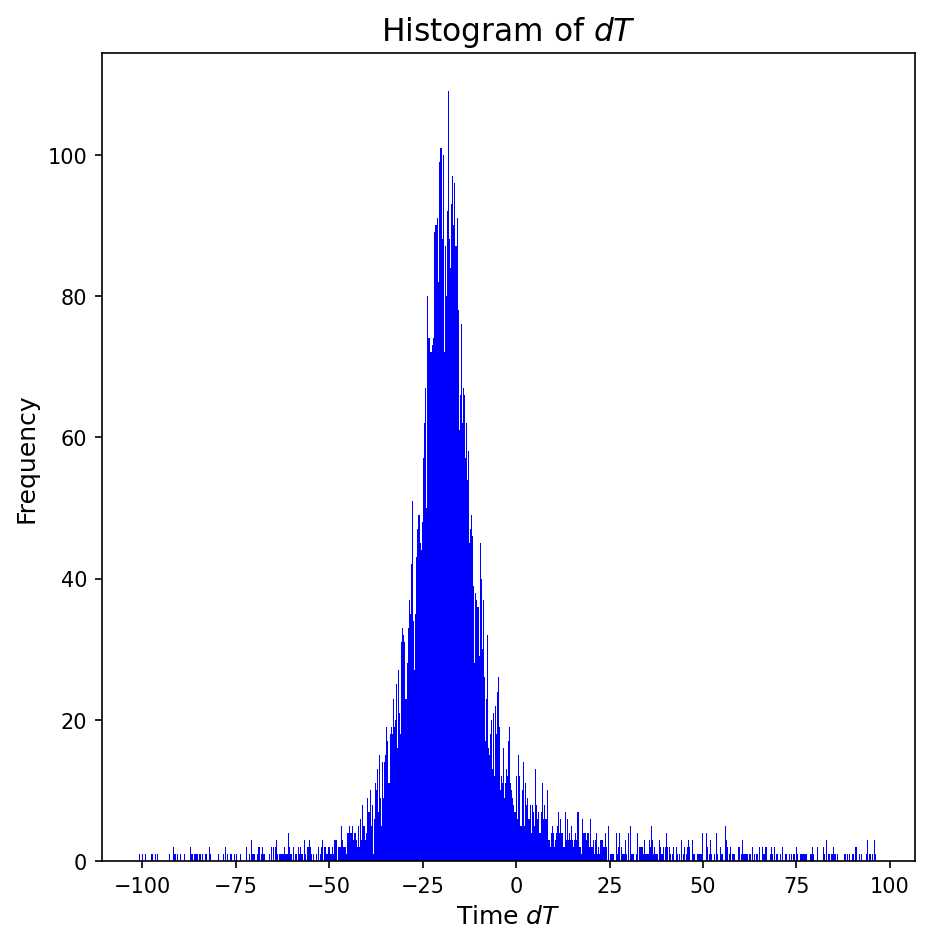

In [29]:
#--- Create a histogram of dT

fig = plt.figure(figsize=(7, 7))

plt.title(r"Histogram of $dT$", fontsize=15)

plt.hist(data_np.T[2], bins=800, color="blue")

plt.xlabel(r"Time $dT$", fontsize=12)
plt.ylabel(r"Frequency", fontsize=12)

#plt.savefig('Histogram of dT - Raw.png', bbox_inches='tight')
plt.show()

In [46]:
#--- Create a histogram 

y_pdf, bins = np.histogram(data_np.T[2], bins=800, density=True)
x_pdf = (bins[:-1] + bins[1:])/2

#--- Test whether the distribution is normal

print(sps.normaltest(data_np.T[2]))
print(sps.normaltest(y_pdf))

NormaltestResult(statistic=3290.1013455821667, pvalue=0.0)
NormaltestResult(statistic=490.069231720609, pvalue=3.826647486830292e-107)


In [52]:
#--- Fit functions to the histogram:

models = {
    "Normal": lambda x, a, b: sps.norm.pdf(x, loc=a, scale=b),
    "Lorentzian": lambda x, a, b: sps.cauchy.pdf(x, loc=a, scale=b)
}

popt_list = []
pcov_list = []

for f in models.values():
    popt, pcov = sop.curve_fit(f, x_pdf, y_pdf,)
    
    popt_list.append(popt)
    pcov_list.append(pcov)

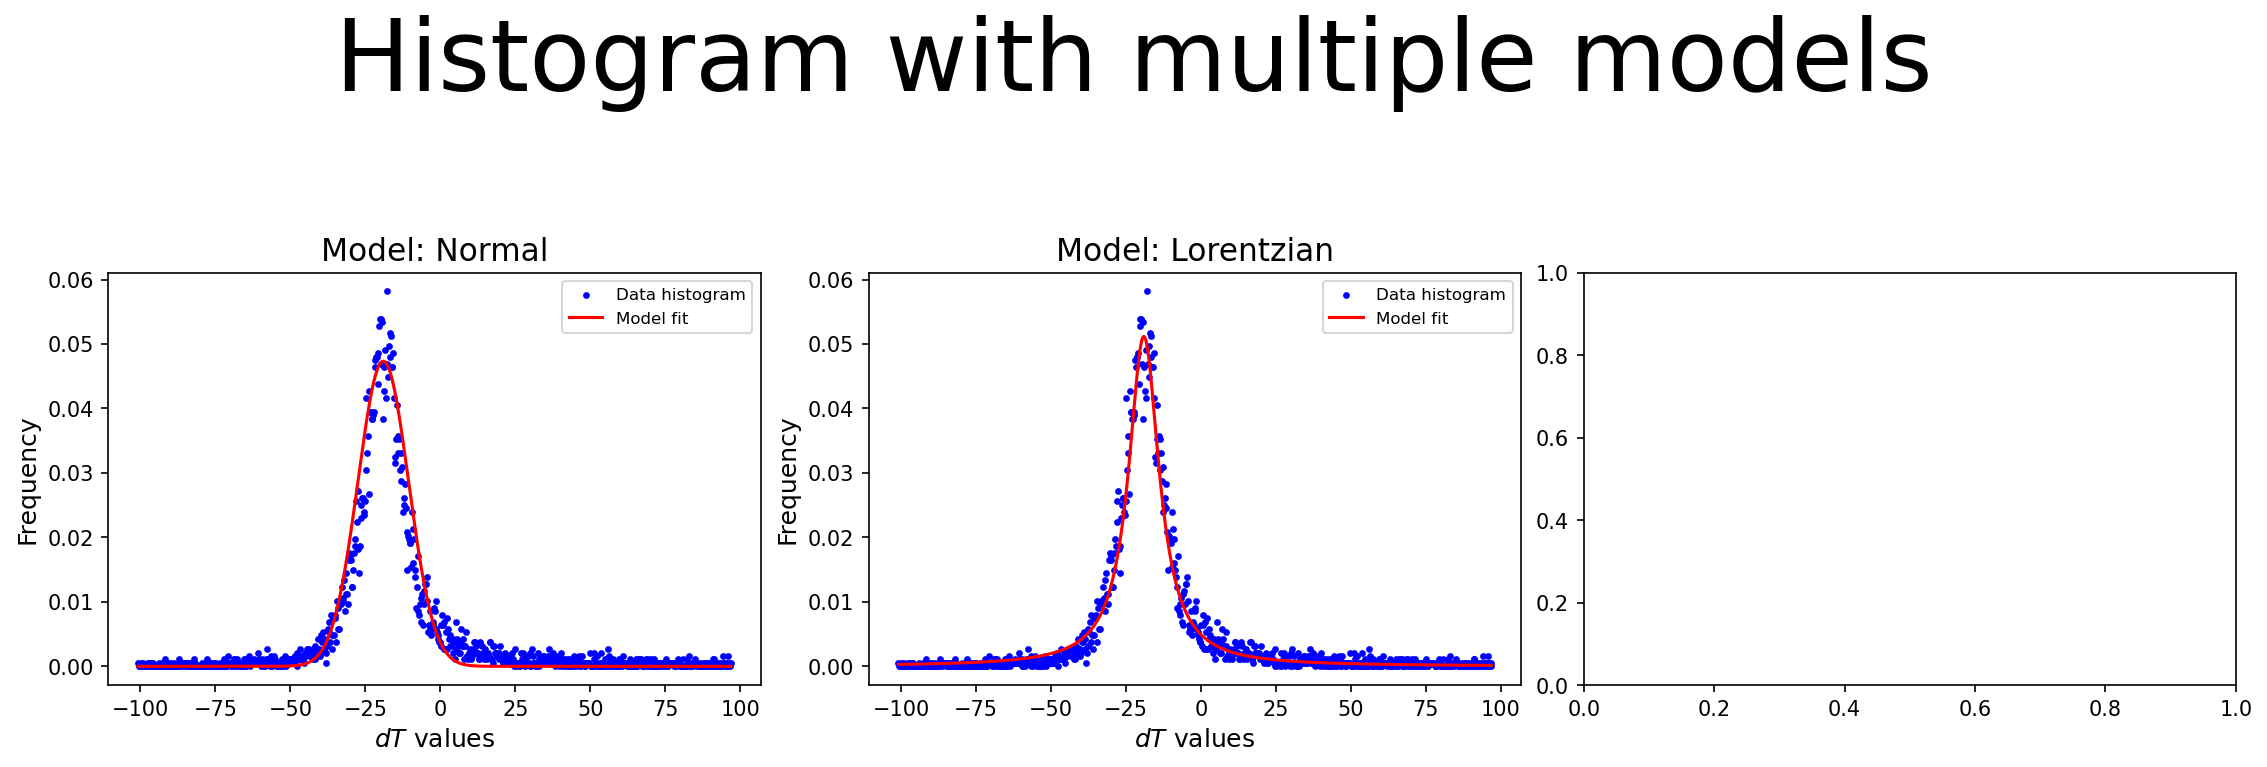

In [57]:
#--- Define a function to do the histogram plots:

def histogram_plotter(ax, model_name, popt):
    """
    It creates a plot (on 'ax' axis; easy to integrate with subplots)
    of the data set. A histogram plot of dT and a fit to the model.
    
    --- Inputs:
    
    - ax = The axis on which to create the (sub)plot
    - model_name = String. Must be from the 'models' dictionary
    (as of now: Normal, Lorentzian).
    - popt = array-like. The values of the parameters to be passed to the 
    model function plotted alongside the data
    
    --- Returns:
    
    - axis is changed according to the specifications
    """
    
    # Extract variables
    f = models[model_name]
    
    # Fit function - arrays
    x_vals = np.linspace(x_pdf.min(), x_pdf.max(), 1000)
    y_vals = f(x_vals, *popt)
    
    # The plotting
    ax.set_title(f"Model: {model_name}", fontsize=15)
    
    ax.scatter(x_pdf, y_pdf, c="blue", s=5, label="Data histogram")
    ax.plot(x_vals, y_vals, color="red", label="Model fit")
    
    ax.legend(fontsize=8)
    ax.set_xlabel(r"$dT$ values", fontsize=12)
    ax.set_ylabel(r"Frequency", fontsize=12)
    
def histogram_subplotter(save_fig=False):
    """
    Creates a subplot of each model given from "models". It relies on the function 
    histogram_plotter.
    
    --- Inputs:
    
    indices_1, indices_2 = Array-like. Each contains a list of all index_1, 
    respectively index_2 variables to be used by scatter_plotter. Both must
    have the same length!
    
    save_fig = Boolean. If true, it saves the subplots as a PNG
    
    --- Returns:
    
    A subplot.
    """
    
    num_rows = max(len(models) // 3, 1)
    
    fig, axs = plt.subplots(num_rows, 3,
                       figsize=(15, 5 * num_rows),
                       constrained_layout=True)

    for ax, model_name, popt in zip(axs.flatten(), models.keys(), popt_list):
        histogram_plotter(ax, model_name, popt)

    fig.suptitle('Histogram with multiple models\n', size=48)
    
    if save_fig == True:
        plt.savefig('Histogram plots of dT.png', bbox_inches='tight')
    
    plt.show()
    
histogram_subplotter()

In [63]:
#--- Test goodness of fits

print(sps.goodness_of_fit(sps.norm, y_pdf))
print(sps.goodness_of_fit(sps.cauchy, y_pdf))

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.005053294571195105, scale=0.01091072815871501)
 success: True
 message: 'The fit was performed successfully.', statistic=159.42006978913867, pvalue=0.0001, null_distribution=array([0.72655811, 0.24152762, 0.47258084, ..., 0.382927  , 0.34655153,
       0.45720403]))
GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.0005200885333886676, scale=0.0006558076518929217)
 success: True
 message: 'The fit was performed successfully.', statistic=126.42932594398712, pvalue=0.0001, null_distribution=array([1.40156176, 0.91577659, 0.60709845, ..., 0.27556977, 0.22690619,
       0.43744697]))


# Training the algorithms

Steps:

1. Split the data set into training and testing

- Keep $70\%$ for training. Also shuffle it
- Not to be standardized!

2. Apply the Neural Network model 
- **Hyperparameters to be optimized**. Take inspiration from https://www.youtube.com/watch?v=BoaHul6TXCE&t=13s&ab_channel=BetterDataScience
- **Different architectures of neural networks?**

3. Analyze the distribution of the residuals. If the model is good, the residuals will be normally N(0, var) distributed. The standard deviation of the residual distribution = the resolution (that, or 1.96 * std for the 95% confidence interval)

Future ideas:

- Plot both prediction and label versus each of the features, to see which fails most (in the same spirit as the *confusion matrix*)
- Try out the other features (or more features) for which the correlation was stronger.

In [4]:
#--- Create function to select features and convert to NP

def get_data_features(features_list):
    """
    This function takes the pandas data frame 'data'
    and splits it into a training and a testing set.
    Only the features in 'features_list' are kept among
    the column of covariates.
    
    --- Inputs:
    
    features_list = list. It contains the columns of the covariates
    that will be kept for later training
    
    --- Outputs:
    
    list with 4 elements, each representing 
    X_train, X_test, Y_train, Y_test
    
    """
    
    # Change to the features list that I want to investigate
    Y = data[["dT"]]
    X = data[features_list]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=42)
    
    # To numpy
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    Y_train_np = Y_train.to_numpy()
    Y_test_np = Y_test.to_numpy()
    
    return [X_train_np, X_test_np, Y_train_np, Y_test_np]

In [5]:
#--- Split the dataset

# Keep only relevant columns from the 
# earlier analysis
features_list = ["I_0.3", "I_0.4", "I_0.5", "T_0.3", "T_0.4", "T_0.5"]
features_list_Ts = ["T_0.1", "T_0.2", "T_0.3", "T_0.4", "T_0.5", "T_0.6", "T_0.7", "T_0.8"]
features_list_Is = ["I_0.1", "I_0.2", "I_0.3", "I_0.4", "I_0.5", "I_0.6", "I_0.7", "I_0.8"]

# data in numpy format with given features

data_np = get_data_features(features_list)         # default value
data_np_Ts = get_data_features(features_list_Ts)   # Keep all Ts
data_np_Is = get_data_features(features_list_Is)   # Keep all Is

input_shape_ = (len(features_list_Ts),)

In [5]:
data_np_Is[0].shape, data_np_Is[1].shape, data_np_Is[2].shape, data_np_Is[3].shape

((5304, 8), (2274, 8), (5304, 1), (2274, 1))

In [6]:
#--- Create function to predict the values

def get_predictions(model,
                   data=data_np,
                   plot_hist=False,
                   add_labelvals=False):
    """
    This function predicts both the training and the 
    test data, given a model. It can also plot a histogram
    of the predicted values against the label values.
    
    --- Inputs:
    
    model = tensorflow or sklearn object. It must be a model already
    defined and trained on the data, prior to calling
    this function
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    plot_hist = Boolean. If true, the function also returns
    a histogram plot of the predicted values, split into training
    and testing sets
    
    add_labelvals = Boolean. If true, to the above histogram the 
    histogram for the label values is also overlapped
    
    --- Returns:
    
    Matplotlib figure, if the option is enabled.
        
    (Yhat_train, Yhat_test) = A tuple with the predicted arrays
    for both train data and test data
    """
    
    # Obtain sizes
    N_train = len(data[2])
    N_test = len(data[3])
    N_total = N_train + N_test
    
    # Predict
    Yhat_train = model.predict(data[0])
    Yhat_test = model.predict(data[1])
        
    # Plot the histogram of predicted dT (and maybe label dTs)
    if plot_hist == True:       
        # Reshape arrays for plotting purposes
        Yhat_train_reshaped = Yhat_train.reshape((N_train,))
        Yhat_test_reshaped = Yhat_test.reshape((N_test,))
        Y_train_np_reshaped = data[2].reshape((N_train,))
        Y_test_np_reshaped = data[3].reshape((N_test,))

        # Plot
        fig = plt.figure(figsize=(5, 3))
        
        plt.hist(Yhat_train_reshaped, bins=N_total//100, alpha=0.5, color="r",
                 density=False, label="Predicted - train")
        
        plt.hist(Yhat_test_reshaped, bins=N_total//100, alpha=0.5, color="b",
                 density=False, label="Predicted - test")
        
        if add_labelvals == True:
            
            plt.hist(Y_train_np_reshaped, bins=N_total//100, alpha=0.5, color="green",
                     density=False, label="Label - train")
            
            plt.hist(Y_test_np_reshaped, bins=N_total//100, alpha=0.5, color="orange",
                     density=False, label="Label - test")
        
        plt.title("Predicted dT values", fontsize=15)
        plt.xlabel("dT", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.legend()
        plt.show()
    
    return (Yhat_train, Yhat_test)

def get_residues(fitted_values, 
                data=data_np,
                plot_residues=False, 
                test_norm=False):
    """
    This function computes the residues. It can also plot a histogram
    of the predicted values against the label values.
    
    --- Inputs:
    
    fitted_values = list or tuple. Its format is (Yhat_train, Yhat_test)
    as returned by get_predictions()
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes
    like data_np (the pandas dataframe converted into numpy straight away)
    
    plot_residues = the histogram of residues for predicted and
    label data
    
    test_norm = applies a normality test to see if the residues are
    normally distributed. The closer to normality they are, the better
    the initial prediction.
    
    --- Returns:
    
    Matplotlib figure, if the option is enabled.
        
    (Yhat_train, Yhat_test) = A tuple with the predicted arrays
    for both train data and test data
    """
    
    # Obtain predictions
    Yhat_train, Yhat_test = fitted_values
    
    # Obtain sizes
    N_train = len(data[2])
    N_test = len(data[3])
    N_total = N_train + N_test
    
    # Compute residues
    residue_train = data[2] - Yhat_train
    residue_test = data[3] - Yhat_test
    
    # Plot the histogram of residues
    if plot_residues == True:
        # Reshape arrays for plotting purposes
        residue_train_reshaped = residue_train.reshape((N_train,))
        residue_test_reshaped = residue_test.reshape((N_test,))
        
        # PLot
        fig = plt.figure(figsize=(5, 3))
        
        plt.hist(residue_train_reshaped, bins=N_total//100, alpha=0.3,
                 density=True, color="b", label="Train")
        
        plt.hist(residue_test_reshaped, bins=N_total//100, alpha=0.3,
                 density=True, color="r", label="Test")
        
        plt.title("Residue distribution", fontsize=15)
        plt.xlabel("Residue", fontsize=12)
        plt.ylabel("Normalized frequency", fontsize=12)
        plt.legend()
        plt.show()
    
    # Normal Test
    if test_norm == True:
        pval_train = sps.normaltest(residue_train).pvalue
        pval_test = sps.normaltest(residue_test).pvalue
        
        print(f"p-value for normality of train: {pval_train}")
        print(f"p-value for normality of test: {pval_test}\n")
    
    return (residue_train, residue_test)

def get_resolutions(residues, 
                  data=data_np,
                  method="std"):
    """
    The function returns the resolution of the predictions
    for both the training and the testing data sets.
    
    The resolution can be defined in multiple ways:
    - as the standard deviation of all residues ("std")
    - as the mean of the absolute value of all residues ("mean")
    
    --- Inputs:
    
    residues = The return of get_residues()
    
    data =  list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes
    like data_np (the pandas dataframe converted into numpy straight away)
    
    method = string. It determines which definition is applied when 
    finding the resolution. See the definitions above for the options
    
    --- Outputs:
    
    A tuple (resolution_train, resolution_test) containing the resolutions
    for both the training and the testing sets.
    """
    
    # Resolutions
    if method == "std":
        resolution_train = np.std(residues[0])
        resolution_test = np.std(residues[1])
        
        return (resolution_train, resolution_test)
    
    elif method == "mean":
        resolution_train = np.mean(np.abs(residues[0]))
        resolution_test = np.mean(np.abs(residues[1]))
        
        return (resolution_train, resolution_test)
    
    else:
        print("Invalid method!")
        return (np.inf, np.inf)

#--- Define joint function for ease of implementation:

def predictor(model, 
              data=data_np,
              plot_hist=False,  
              add_labelvals=False,
              plot_residues=False,
              test_norm=False,
              add_resolutions=False,
              method='std'):
    """
    This function provides an integrated API for calling
    all three of the functions above. Mainly for comfort 
    purposes.
    
    --- Inputs:
    
    model = tensorflow or sklearn object. It must be a model already
    defined and trained on the data, prior to calling
    this function
    
    data =  list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes
    like data_np (the pandas dataframe converted into numpy straight away)
    
    plot_hist = Boolean. If true, the function also returns
    a histogram plot of the predicted values, split into training
    and testing sets
    
    add_labelvals = Boolean. If true, to the above histogram the 
    histogram for the label values is also overlapped
    
    plot_residues = the histogram of residues for predicted and
    label data
    
    test_norm = applies a normality test to see if the residues are
    normally distributed. The closer to normality they are, the better
    the initial prediction.
    
    add_resolutions = Boolean. If true, it prints nicely the 
    resolutions corresponding to each data set (train/test).
    
    method = string. It determines which definition is applied when 
    finding the resolution. See the definitions above for the options
    
    --- Outputs:
    
    Depending on which boolean is set to true, it returns 
    figures or printed statements.
    """
    
    # Predict the data
    predictions = get_predictions(model, data=data, plot_hist=plot_hist,
                                 add_labelvals=add_labelvals)
    # Compute residues
    residues = get_residues(predictions, data=data,
                            plot_residues=plot_residues, test_norm=test_norm)
    
    # Find resolution
    if add_resolutions == True:
        resolutions = get_resolutions(residues, data=data, method=method)
        
        print(f"Method: {method}")
        print(f"Resolution - train set: {resolutions[0]}")
        print(f"Resolution - test set: {resolutions[1]}")

## Neural Network Regression

I want a Deep Neural Network or a Multilayer Perceptron (MLP) - Feed Forward NN.

**Issue**
- Reproducibility. Setting the tensorflow seed is not enough, it seems... possible source from where to fix this: https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

**TBD**

- Train all these models and save the results on a separate file
- Optimize the architecture for the NNs

### Functions that generate, train and save Sequential NN models

In [7]:
#--- Define function to create a model

def get_model(nodes_per_layer: list,
             input_shape: tuple = input_shape_,
             hidden_layer_activation: str = 'relu',
             num_nodes_at_output: int = 1,
             output_layer_activation: str = 'linear'):
    """
    This function creates a tensorflow (keras) sequential model,
    but without actually compiling the model. 
    
    --- Input:
    
    nodes_per_layer = list. It gives the number of nodes that 
    each layer will have, in order. Its length is the number of 
    hidden layers
    
    input_shape = tuple. It gives the shape of the input layer;
    It is of the form (#Features,) - ignoring the number of data
    points
    
    hidden_layer_activation = string. It gives the activation function
    of the hidden layers. 
    
    num_nodes_at_output = integer. It gives the number of nodes that
    the output layer has
    
    output_layer_activation = string. It gives activation function of the
    output layer. By default it is set to 'linear', which is appropriate
    for a regression task
    
    --- Output:
    
    model = keras.src.engine.sequential.Sequential. A non-compiled
    tensorflow sequential model
    """
    
    # Create sequential model
    model = tf.keras.Sequential()
    
    # Change name for ease of tracking
    model_name = ''
    model_name += hidden_layer_activation + '_'
    
    # Add input layer
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    # Add the hidden layers
    for nodes in nodes_per_layer:
        model.add(tf.keras.layers.Dense(nodes, activation=hidden_layer_activation))
        # Append to name
        model_name += f'{nodes}_'
    
    # Add output layer
    model.add(tf.keras.layers.Dense(num_nodes_at_output, activation=output_layer_activation))
    
    # Set the name of the model
    model._name = model_name[:-1]
    
    return model

#--- Define function to create many models:

def get_models(nodes_per_layer_list: list,
               input_shape: tuple = input_shape_,
               hidden_layer_activation: str = 'relu',
               num_nodes_at_output: int = 1,
               output_layer_activation: str = 'linear'):
    """
    The function generates a list of models, as created by the
    get_model() function. The only difference is that now each 
    model will have nodes_per_layer as given by the elements of 
    nodes_per_layer_list.
    """
    
    # Create a list of models   
    models = []
    
    for nodes_per_layer in nodes_per_layer_list:
        temp = get_model(nodes_per_layer, input_shape=input_shape,
                        hidden_layer_activation=hidden_layer_activation,
                        num_nodes_at_output=num_nodes_at_output,
                        output_layer_activation=output_layer_activation)
        models.append(temp)
    
    return models

#--- Function to train a model

def train(model, 
         data=data_np,
         loss=tf.keras.losses.mse,
         optimizer=tf.keras.optimizers.legacy.Adam(),
         metrics=['mse']):
    """
    The function compiles and trains a tf sequential
    model to the training data data.
    
    --- Inputs:
    
    model = tf.sequential.Sequential object. The tensor
    flow model to be modified
    
    data = list. It consists of a list [X, Y] containing the 
    training data and testing data. See predictor() for details
    
    loss, optimizer = tf.keras objects. They represent the 
    loss function and the optimizer to be used when training
    
    metrics = list. It is a list contaning a string with the
    metric that is optimized when fitting the function. An 
    alternative to this is ['mae'].
    
    --- Outputs:
    
    None. The model in the argument is modified and fitted
    """
    
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=metrics)
    
    # Fit the model
    model.fit(data[0], data[2], epochs=100, verbose=0)

#--- Functions that save or load a trained model

def save_model(model, 
        path_folder='C:/Users/andre/Python Notebooks/ML Myroslav Project/Saved Models/'):
    """
    This function saves a given tensorflow model in the folder
    given by the path 'path_folder'
    
    Inspired from:
    https://www.tensorflow.org/guide/keras/serialization_and_saving
    
    --- Returns:
    
    Besides saving the model, the function returns the path of the 
    saved file, including its name and '.keras' extension
    """
    
    # Save
    path_file = path_folder + model.name + '.keras'

    model.save(path_file)
    
    return path_file

def load_model(path_file):
    """
    This function loads a tensorflow model
    given by the path 'path_file'
    
    Inspired from:
    https://www.tensorflow.org/guide/keras/serialization_and_saving
    
    --- Returns:
    
    Tensorflow model. It should already be defined, compiled and fitted 
    to the training data; ready to use for predictions
    """
    
    # Load
    return tf.keras.models.load_model(path_file)

#--- Define a function to create layer-node permutations:

def get_layer_node_permutations(num_layers: int,
               min_nodes_per_layer: int,
               max_nodes_per_layer: int,
               node_step_size: int):
    """
    In mathematical terms, the function generates the cartesian
    product of the set A = range(min_nodes, max_nodes + 1, step_size)
    repeated num_layers times:
    
    A X A X A X ... X A
    
    --- Inputs:
    
    num_layers = Integer. It gives the number of nodes that 
    each layer will have, in order. Its length is the number of 
    hidden layers. In this context: the number of times we take the
    cartesian product
    
    min_nodes_per_layer = Integer. The minimal number of nodes a layer
    is allowed to have.
    
    max_nodes_per_layer = Integer. The maximal number of nodes a layer
    is allowed to have (inclusive).
    
    node_step_size = Integer. The spacing between allowed number of nodes
    
    --- Returns:
    
    A list of tuples. Each tuple consists of a permutation of num_layers
    elements samples from the set A.
    
    --- Example:
    
    get_layer_node_permutations(2, 5, 7, 1)
    > [(5, 5), (5, 6), (5, 7), (6, 5), (6, 6), (6, 7), (7, 5), (7, 6), (7, 7)]
    """
    
    # Possible number of nodes
    node_options = list(range(min_nodes_per_layer, max_nodes_per_layer+1, node_step_size))
    
    # Repeat the above num_layers times
    layer_possibilities = [node_options] * num_layers
    
    # Generate permutations of the above 
    # = all possible arrangements of number of nodes per layer
    layer_node_permutations = list(itertools.product(*layer_possibilities))
    
    return layer_node_permutations

#### Test these functions

In [101]:
model_test = get_model([10, 10, 10, 10, 10, 10, 10],
                     hidden_layer_activation='linear',
                      input_shape=(6,))
train(model_test,optimizer=tf.keras.optimizers.legacy.Adam())
model_test.summary()

Model: "linear_10_10_10_10_10_10_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_393 (Dense)           (None, 10)                70        
                                                                 
 dense_394 (Dense)           (None, 10)                110       
                                                                 
 dense_395 (Dense)           (None, 10)                110       
                                                                 
 dense_396 (Dense)           (None, 10)                110       
                                                                 
 dense_397 (Dense)           (None, 10)                110       
                                                                 
 dense_398 (Dense)           (None, 10)                110       
                                                                 
 dense_399 (Dense)           (None, 10)

72/72 [==============================] - 0s 1ms/step


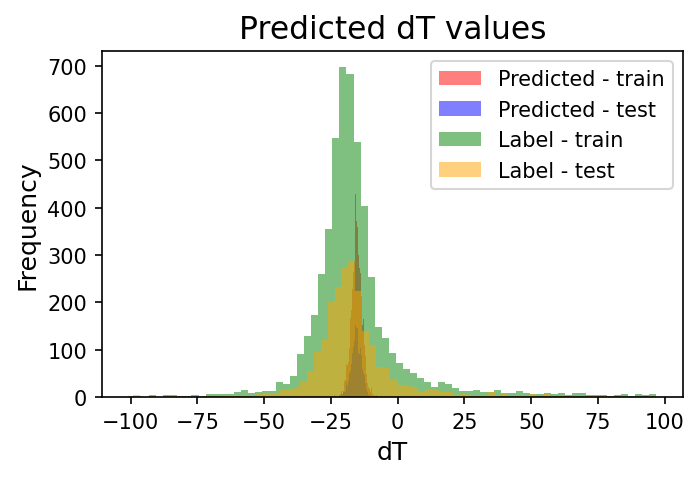

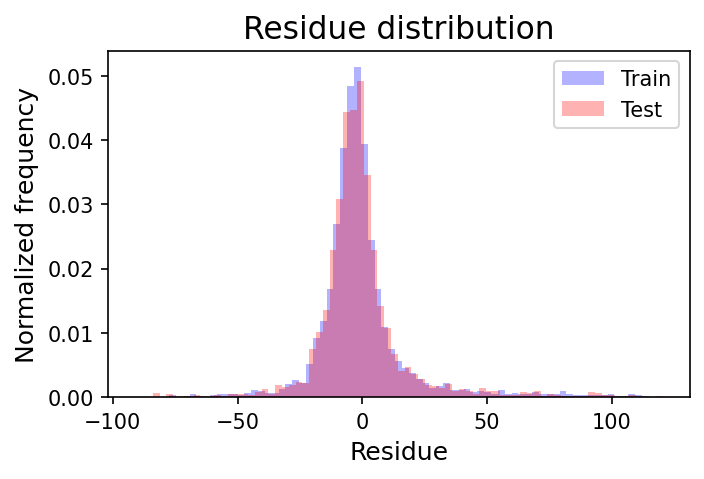

Method: std
Resolution - train set: 19.46398726883246
Resolution - test set: 18.89156972209824


In [102]:
predictor(model_test, plot_hist=True, plot_residues=True,
          add_labelvals=True, add_resolutions=True,)

In [104]:
path_file = save_model(model_test)
path_file

'C:/Users/andre/Python Notebooks/ML Myroslav Project/Saved Models/linear_10_10_10_10_10_10_10.keras'

**Reload model**

In [105]:
model_test = load_model('C:/Users/andre/Python Notebooks/ML Myroslav Project/Saved Models/linear_10_10_10_10_10_10_10.keras')

In [106]:
model_test.summary()

Model: "linear_10_10_10_10_10_10_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_393 (Dense)           (None, 10)                70        
                                                                 
 dense_394 (Dense)           (None, 10)                110       
                                                                 
 dense_395 (Dense)           (None, 10)                110       
                                                                 
 dense_396 (Dense)           (None, 10)                110       
                                                                 
 dense_397 (Dense)           (None, 10)                110       
                                                                 
 dense_398 (Dense)           (None, 10)                110       
                                                                 
 dense_399 (Dense)           (None, 10)

### Optimize the model architecture

**General tips**

Meeting summary:
- The model is complex enough (741 parameters). We can even trim it down a bit. We know that we arrive at overfitting when the number of parameters becomes similar to the number of data points.
- We can keep the same architecture, or play around with it: more/less neurons, more/less layers, changing the hidden layer activation function
- The most important area where to play around is with the data that we use. We should focus on using the entire curve (for now), and either all T's or all I's
- We know that the model is good when the residues are all zero.
- There are no good resources that Myroslav has right now. However, he ordered a book with ML for scientists that he will share in January

From the internet:
- The activation function is the main feature that makes NN non-linear and allows for complex behaviour. While the output must be linear (for regression problems), the hidden layers need to be investigated. Choose a non-linear function; worry about performance later (avoid sigmoid or tanh in this case). Link: https://www.turing.com/kb/how-to-choose-an-activation-function-for-deep-learning

#### Test hypotheses

Small comparisons between various models, at small scales. I want to see what kind of conclusions I can draw.

**Comparisons between data sets**

The cells where I did these tests have been lost. However, here is the conclusion:
- A model using only the middle of both features was essentially the same as the model using all Ts at the same time. The number of parameters is approximately the same; linear activation function. Conclusion: either data set is fine for now. Proceed with all Ts

**Different activation functions**

Take a promising model from the grid search below. Will it be just as good if I tweak its activation function?
*Note*. In a previous test: (Linear, All Ts, 7 x 10 layers) = (Relu, All Ts, 7 x 10 layers) identically. Relu was just as good. But in the tests below, 'relu' is even better.

Conclusion: 'relu' is the best activation function. Proceed with that one.

In [156]:
# softplus
model_test_softplus = get_model([8, 6, 8, 8],
                     hidden_layer_activation='softplus')
train(model_test_softplus,optimizer=tf.keras.optimizers.legacy.Adam(),
                           data=data_np_Ts)

# Linear
model_test_linear = get_model([8, 6, 8, 8],
                     hidden_layer_activation='linear',)
train(model_test_linear,optimizer=tf.keras.optimizers.legacy.Adam(),
                           data=data_np_Ts)

# Relu
model_test_relu = get_model([8, 6, 8, 8],
                     hidden_layer_activation='relu',)
train(model_test_relu,optimizer=tf.keras.optimizers.legacy.Adam(),
                           data=data_np_Ts)

# gelu
model_test_gelu = get_model([8, 6, 8, 8],
                     hidden_layer_activation='gelu',)
train(model_test_gelu,optimizer=tf.keras.optimizers.legacy.Adam(),
                           data=data_np_Ts)

In [158]:
predictor(model_test_softplus, data=data_np_Ts,
          add_resolutions=True,)

predictor(model_test_linear, data=data_np_Ts,
          add_resolutions=True,)

predictor(model_test_relu, data=data_np_Ts,
          add_resolutions=True,)

predictor(model_test_gelu, data=data_np_Ts,
          add_resolutions=True,)

72/72 [==============================] - 0s 1ms/step
Method: std
Resolution - train set: 18.243961132065284
Resolution - test set: 18.117027511378716
72/72 [==============================] - 0s 990us/step
Method: std
Resolution - train set: 18.946637658785946
Resolution - test set: 18.298817286239682
72/72 [==============================] - 0s 971us/step
Method: std
Resolution - train set: 18.649992006009896
Resolution - test set: 18.074371379849985
72/72 [==============================] - 0s 1ms/step
Method: std
Resolution - train set: 18.583078374433516
Resolution - test set: 18.07345982389827


**Grid search with many layers**

For this test, I keep relu and play with the number of hidden layers when we already have a lot of layers and nodes. Find the lowest resolution possible on the testing set. Is there a big improvement from the cases with few layers?

- 6 x 10 + {0, 5, 6, 7, 8, 9}: 18.055, 18.068, 17.564, 17.966, 17.745, 17.955
- 5 x 10 + 6 + 10: 17.529
- 3 x 10 + 6 + 3 x 10: 17.918

Conclusion: the lowest I could get is $17.53$, which is not radically better than the models with 4 layers. Conclusion: at a first glance, increasing the number of parameters through layers and nodes is futile. I must check the other hyperparameters available.

#### Grid search
The video that I use to define models in a structured manner and optimize for hyperparameters: https://www.youtube.com/watch?v=BoaHul6TXCE&ab_channel=BetterDataScience

Focus on the model with all Ts, with 'relu' activation function. Search for the optimal number of layers, together with node distribution. Some results - best performance from the given list:
- get_layer_node_permutations(2, 2, 3, 1): (3, 3) - a bit below 19
- get_layer_node_permutations(2, 5, 10, 2): (7, 9) - 18.00
- get_layer_node_permutations(3, 6, 10, 2): (8, 6, 8) - 17.73 and (10, 10, 6) - 17.71
- get_layer_node_permutations(4, 6, 10, 2): (8, 6, 8, 8) - 17.65 (around 20 sec / model)

**Idea**

- Repeat the model computations for 2 and 5 layers. Then plot the resolutions of the tests per each layer *together* in different colours, to see if there is a trend of improvement with increasing number of layers
- Do the fitting procedure as described by Ana. Further details to be added

In [8]:
#--- Function to save and train models

def grid_search(permutations_arg, layer_activation="relu",
               data=data_np_Ts, save_files=True,
               save_path="C:/Users/Andrei/Documents/GitHub/TimeResolutionImprovement-ML/Saved Models/"):
    """
    This functions does the following:
    - create a list of models with the numbers of layers and
    nodes as returned by get_layer_node_permutations, with the
    hidden layer activation function 'layer_activation'
    - trains these models using the data set 'data'
    - computes the resolutions of these models for the training
    and for the testing sets
    - saves these models, as well as the paths to these models
    
    --- Inputs:
    
    permutations_arg = (4,) tuple. It contains the arguments to be passed
    to the function get_layer_node_permutations(); see its documentation
    for the significance of each number in the parameters
    
    layer_activation = string. It denotes the hidden layer activation function 
    to be used for the training of the models
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    
    save_files = boolean. If true, it will save the trained models, as well
    as the paths to their location in the directory 'save_path'
    
    save_path = string. The path to the directory where the models will be
    saved. The file with the paths themselves will be saved in the same location 
    as the location of this coding file.
    
    --- Returns:
    
    models_list = list. The list with trained models, according to 
    the specifications of get_layer_node_permutatios()
    
    resolutions_train = array. An array with the resolutions computes for 
    each model through the default method. This on the training data set
    
    resolutions_test = array. The same as above, but on the test data set
    
    """
    
    #--- Initialize all lists:
    
    # List of lists. The number of nodes per each layer
    layer_list = get_layer_node_permutations(*permutations_arg)
    # List of models with these nodes
    models_list = get_models(layer_list, 
                            hidden_layer_activation=layer_activation)
    # Resolutions of test data set
    resolutions_train = np.empty(len(layer_list))
    resolutions_test = np.empty(len(layer_list))
    
    if save_files == True:
        # Path files used to reload models, in a list
        path_file_list = []
    
    for i, model in enumerate(models_list):
        train(model, optimizer=tf.keras.optimizers.legacy.Adam(),
             data=data_np_Ts,)

        # Find the resolutions
        predictions = get_predictions(model, data=data)
        residues = get_residues(predictions, data=data)
        resolutions_train[i], resolutions_test[i] = get_resolutions(residues,
                                                                data=data,)
        # Save models
        if save_files == True:
            temp = save_model(model, path_folder=save_path)
            path_file_list.append(temp)
    
    if save_files == True:
        # Save to separate file
        metafile_name = 'paths_for_models_' + layer_activation + f'_{permutations_arg}.csv'
        np.savetxt(metafile_name, path_file_list, 
               delimiter =",", fmt ='% s',)
    
    return models_list, resolutions_train, resolutions_test

def plot_resolutions(resolutions, group='Test'):
    """
    This function creates a scatter plot of the resolutions 
    in 'resolutions' as function of the index of the model
    in which it is placed in 'models_list', as returned by 
    grid_search()
    
    --- Inputs:
    
    resolutions = array. The array with the resolutions (computed
    via 'mse' through get_resolutions()) for each model in 
    'models_list', in order.
    
    group = string. "Test" or "Training", depending on which resolutions
    are plotted
    
    --- Output:
    
    A matplotlib figure.
    """
    
    # Create the figure
    fig = plt.figure(figsize=(7, 4))

    plt.title(f"Resolutions vs. Models \n{group} Set ", fontsize=18)

    plt.scatter(range(len(resolutions)), resolutions,
               color="blue", s=5)

    plt.xlabel("Model index in the list", fontsize=12)
    plt.ylabel("Resolution = MSE of residues", fontsize=12)

    plt.minorticks_on()
    
def reload_grid_search(paths_location, data=data_np_Ts):
    """
    The function reloads the models computed and saved by
    a previous calling of grid_search(, save_files=True).
    
    The function further recompputes the resolutions for these
    reloaded models, by the same method as grid_search().
    
    --- Inputs:
    
    paths_location = string. It represents the name of the file which
    contains the list of strings that further contains the location 
    and names of the models previously computed and saved.
    
    data = a list with [X_train, X_test, Y_train, Y_test] **in this
    order**. Each element is assumed to be a numpy array of shapes:
    (#1, n), (#2, n), (#1, 1), (#2, 1); where
    #1 = the number of training data points
    #2 = the number of testing data points
    n = len(features_list)
    !!! Ideally, it is the data set which was used to train the previous models.
    
    --- Returns:
    
    models_list = list. The list with trained models, according to 
    the specifications of get_layer_node_permutatios()
    
    resolutions_train = array. An array with the resolutions computes for 
    each model through the default method. This on the training data set
    
    resolutions_test = array. The same as above, but on the test data set
    """
    
    # Paths to the file in which the models are saved
    paths = np.loadtxt(paths_location,dtype=np.str_,
                  delimiter=",")
    models_list = []

    for path in paths:
        model_temp = load_model(path)
        models_list.append(model_temp)

    #--- Recompute resolutions
    resolutions_train = np.empty(len(models_list)) # Prev: layer_list
    resolutions_test = np.empty(len(models_list))

    for i, model in enumerate(models_list):
        # Find the resolutions
        predictions = get_predictions(model, data=data)
        residues = get_residues(predictions, data=data)
        resolutions_train[i], resolutions_test[i] = get_resolutions(residues,
                                                                   data=data)
        
    return models_list, resolutions_train, resolutions_test

In [20]:
# List of number nodes per each layer
# and the hidden layer activation
permutations_arg = (1, 6, 10, 2)
layer_activation = 'relu'

models_list, resolutions_train, resolutions_test = grid_search(permutations_arg, layer_activation=layer_activation)

72/72 [==============================] - 0s 1ms/step


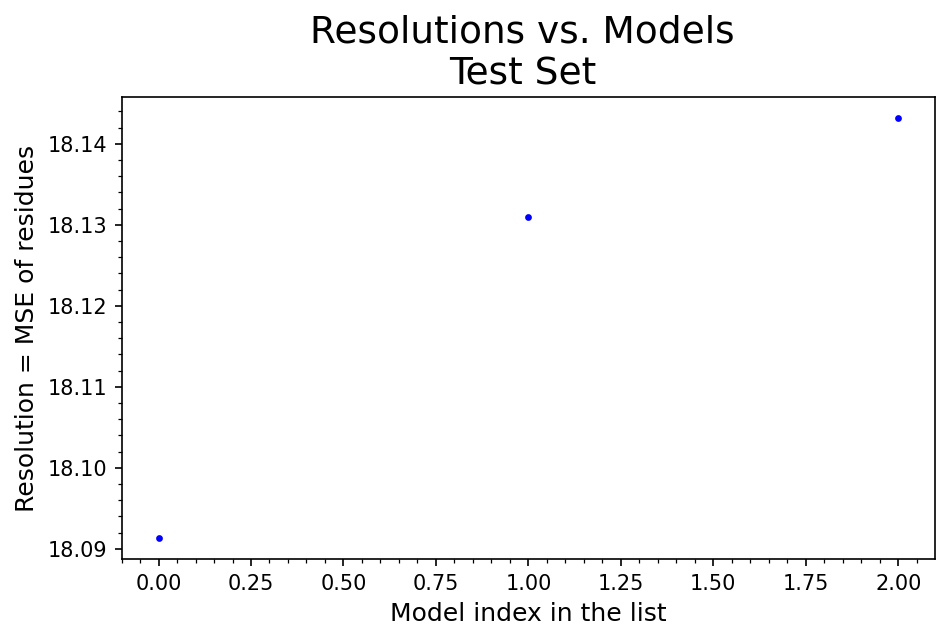

In [22]:
plot_resolutions(resolutions_test)

Model: "relu_6_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 54        
                                                                 
 dense_4 (Dense)             (None, 8)                 56        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 119 (476.00 Byte)
Trainable params: 119 (476.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
72/72 [==============================] - 0s 1ms/step


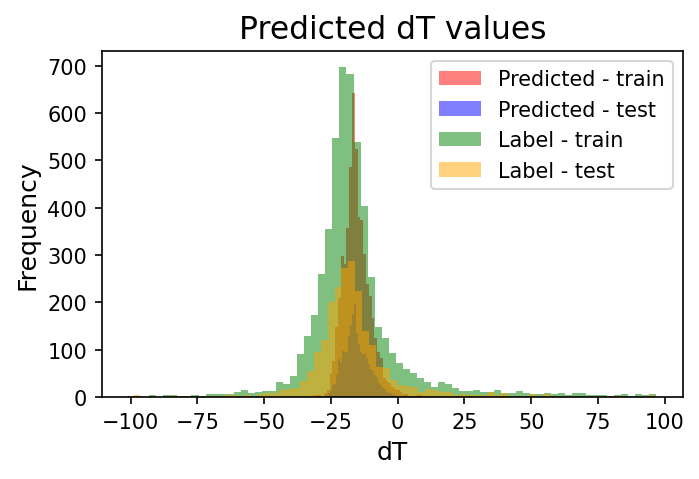

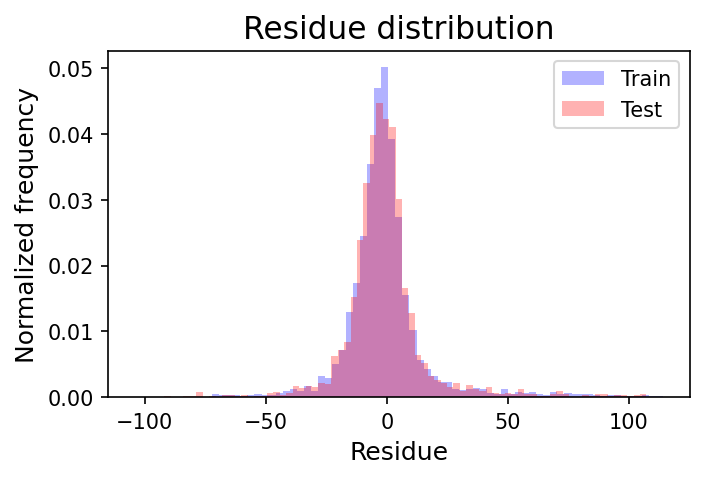

Method: std
Resolution - train set: 18.570987808554253
Resolution - test set: 17.954873752249686


In [13]:
# Model at index to be investigated
index = 1

# Model summary
models_list[index].summary()
predictor(models_list[index], data=data_np_Ts, plot_hist=True,
          add_labelvals=True, add_resolutions=True,
         plot_residues=True)

**Reload models from Grid Search**

In [9]:
models_list, resolutions_train, resolutions_test = reload_grid_search("paths_for_models_relu_(4, 6, 10, 2).csv",)


72/72 [==============================] - 0s 1ms/step


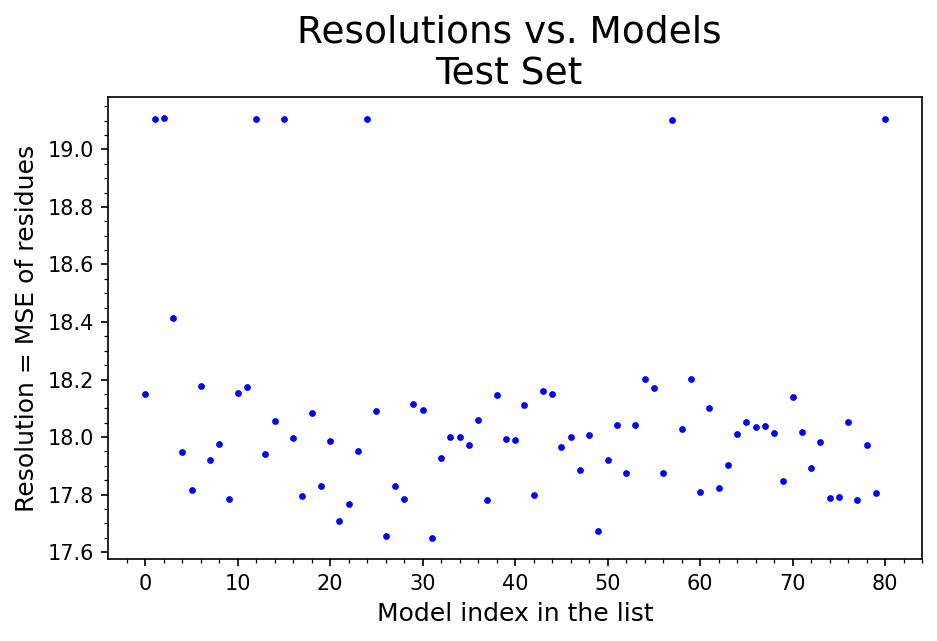

In [10]:
plot_resolutions(resolutions_test)

Model: "relu_8_6_8_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_664 (Dense)           (None, 8)                 72        
                                                                 
 dense_665 (Dense)           (None, 6)                 54        
                                                                 
 dense_666 (Dense)           (None, 8)                 56        
                                                                 
 dense_667 (Dense)           (None, 8)                 72        
                                                                 
 dense_668 (Dense)           (None, 1)                 9         
                                                                 
Total params: 263 (1.03 KB)
Trainable params: 263 (1.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
72/72 [=================

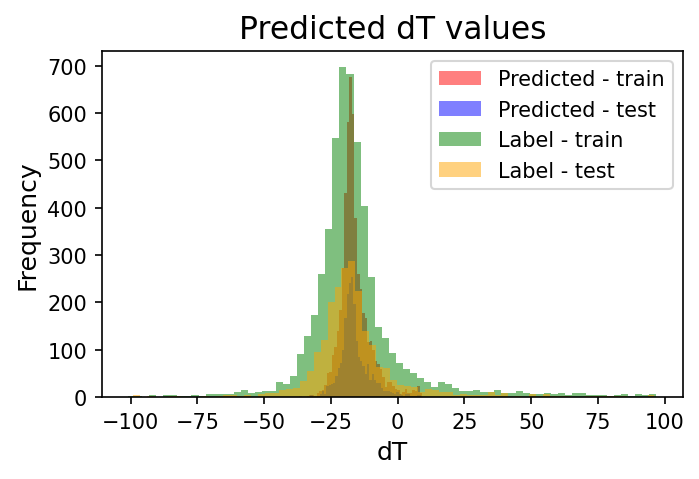

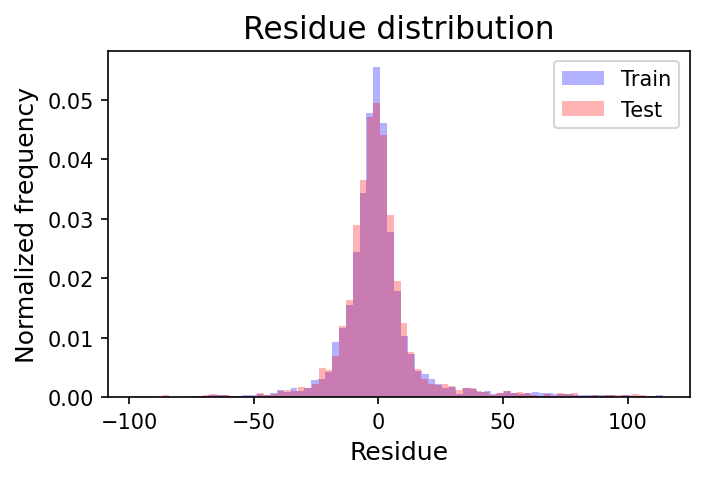

Method: std
Resolution - train set: 18.28799896713665
Resolution - test set: 17.648788799870474


In [11]:
# Model at index to be investigated
index = 31

# Model summary
models_list[index].summary()
predictor(models_list[index], data=data_np_Ts, plot_hist=True,
          add_labelvals=True, add_resolutions=True,
         plot_residues=True)